# Transfer Learning and feature extraction

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/02_transfer_learning.ipynb)

Comparison of different feature extraction methods vs. direct learning from the raw image data. Note this notebooks runs about 10 minutes on a CPU, so it is recommended to run it on a GPU.

## Settings and Configurations

Choose your dataset, name of the feature extractor by moving the respective variables.

In [75]:
# Select Data Set to use
data_set_name = '5Classes' #Currently only tested with CIFAR10
data_set_name = 'CIFAR10'

# Select the pre-trained NN that is used as feature extractor
extractor_name = 'mobilnet'
extractor_name = 'ResNet-18'
extractor_name = 'swin'
extractor_name = 'VGG16'

# Number of test_data to use
num_test_data =  2000     # 2000 total number of testdata
train_img_per_class = 100 # Set to 100

do_augmentation = False   # Does Augmentation for the baseline CNN training, slows down training time significatly

#Just set to True if you want store the data in g-drive
STORE_IN_DRIVE_Oliver = False

In [76]:
if data_set_name == '5Classes':
  num_classes = 5
elif data_set_name == 'CIFAR10':
  num_classes = 10

In [77]:
# prompt: Mount my drive
if STORE_IN_DRIVE_Oliver:
  import locale
  def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
  locale.getpreferredencoding = getpreferredencoding

  from google.colab import drive
  drive.mount('/content/drive')

  PATH = "/content/drive/My Drive/models/"

else:
  PATH = "./"

# List the content of the PATH in python and length of files
import os
os.listdir(PATH)

['.config', 'sample_data']

## Imports and Keras Setup

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pylab import *

from PIL import Image
import numpy as np
from tqdm import tqdm

import time
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch

print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

cuda_available = torch.cuda.is_available()
cuda_version = torch.version.cuda if cuda_available else "N/A"
print(f"CUDA Available: {cuda_available}")
print(f"CUDA Version: {cuda_version}")


# Keras Building blocks
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import optimizers

import sys
from IPython.display import display, Markdown

Keras_version: 3.8.0
torch_version: 2.5.1+cu124
keras backend: torch
CUDA Available: True
CUDA Version: 12.4


## CIFAR Data preparation

Creates a Data Set with 100 Examples of each of the 100 Classes. Details are not so important just run it.

In [23]:
#downlad cifar data
from keras.datasets import cifar10
if (data_set_name != 'CIFAR10'):
  display(Markdown('**Skipping Cell: Not CIFAR10 dataset**'))
else:
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()
  #loop over each class label and sample 100 random images over each label and save the idx to subset
  import hashlib
  np.random.seed(seed=222)
  idx=np.empty(0,dtype="int8")
  for i in range(0,len(np.unique(y_train))):
      idx=np.append(idx,np.random.choice(np.where((y_train[0:len(y_train)])==i)[0],train_img_per_class,replace=False))

  x_train= x_train[idx]
  y_train= y_train[idx]
  # Calculate the checksum of the idx array
  idx_checksum = hashlib.md5(idx.tobytes()).hexdigest()
  print(f"Checksum of idx: {idx_checksum}")

  print(x_train.shape)
  print(y_train.shape)
  print(np.unique(y_train,return_counts=True))

  x_train_new = x_train
  y_train_new = y_train

  x_test_new = x_test
  y_test_new = y_test

  from keras.utils import to_categorical
  y_train_new=to_categorical(y_train_new,10)
  y_test_new=to_categorical(y_test_new,10)


  #!!!!!!!! DO NOT Standardize Input Data WHEN DOING FEATURE EXTRACTION !!!!!!!

Checksum of idx: f63c50069520d2927814f7d9e6e99efb
(1000, 32, 32, 3)
(1000, 1)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100]))


## 5 Classes data set

Data set with 1200 Images for training 5 classes. The testset has 400 images pre class.per

In [24]:
import os
import urllib.request
import zipfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

if (data_set_name == '5Classes'):
  # Step 1: Download and extract the Linnaeus 5 dataset from Dropbox
  ## Original from x now at HS24_25_WBL/data/Linnaeus_5_128X128
  url = "https://www.dropbox.com/scl/fi/wo7dcmt6jrg6ggcf9iyui/Linnaeus_5_128X128.zip?rlkey=z6yx35gcpij9lm2cecm3zpxsi&dl=1"
  dataset_dir = "linnaeus5_dataset"
  os.makedirs(dataset_dir, exist_ok=True)

  zip_file_path = os.path.join(dataset_dir, "Linnaeus_5_128X128.zip")

  print("Checking for existing dataset...")
  if not os.path.isfile(zip_file_path):
      print("Downloading Linnaeus 5 Dataset from Dropbox...")
      urllib.request.urlretrieve(url, zip_file_path)
      print("Download completed.")
  else:
      print("Dataset already exists. Skipping download.")

  # Step 2: Extract the dataset if not already extracted
  extracted_dir = os.path.join(dataset_dir, "Linnaeus 5 128X128")
  if not os.path.isdir(extracted_dir):
      print("Extracting the dataset...")
      with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
          zip_ref.extractall(dataset_dir)
      print("Extraction completed.")
  else:
      print("Dataset already extracted. Skipping extraction.")

  # Step 3: Load images and create labels (Y)
  classes = ['berry', 'bird', 'dog', 'flower', 'other']
  image_size = (128, 128)
  # Function to load images with num_images_per_class and 'train' parameter
  def load_images(extracted_dir, num_images_per_class, data_split='train'):
      classes = ['berry', 'bird', 'dog', 'flower', 'other']
      image_size = (128, 128)
      images = []
      labels = []
      for cls in classes:
          cls_dir = os.path.join(extracted_dir, data_split, cls)
          print("Total number of images in train ", cls, " ", len(os.listdir(cls_dir)))
          cls_images = os.listdir(cls_dir)[:min(num_images_per_class, len(os.listdir(cls_dir)))]
          for img_file in cls_images:
              img_path = os.path.join(cls_dir, img_file)
              img = Image.open(img_path).convert('RGB')
              img = img.resize(image_size)
              img_array = np.array(img)
              images.append(img_array)
              labels.append(cls)
      images = np.array(images)
      labels = np.array(labels)
      return images, labels

  # Example usage with the function
  num_images_per_class = 5
  images, labels = load_images(extracted_dir, num_images_per_class)

  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)
  print(labels[0:10])

  import matplotlib.pyplot as plt
  import numpy as np

  # Display shapes for verification
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)
  print(labels[0:10])

  # Unique classes and number of examples per class
  classes = np.unique(labels)
  examples_per_class = 5  # Number of examples per class

  # Prepare figure for displaying images
  fig, axes = plt.subplots(examples_per_class, len(classes), figsize=(12, 12/(5/examples_per_class)))

  idx = []
  for col, cls in enumerate(classes):
      cls_indices = np.where(labels == cls)[0][:examples_per_class]
      for row, idx_1 in enumerate(cls_indices):
          idx.append(idx_1)
          axes[row, col].imshow(images[idx_1].astype('uint8'))
          axes[row, col].axis('off')
          if row == 0:
              axes[row, col].set_title(cls, fontsize=12)

  # Adjust spacing between images
  plt.subplots_adjust(wspace=0.01, hspace=0.01)

  plt.show()
  imgs, y_train = load_images(extracted_dir, 1200, data_split='train')
  imgs_test, y_test = load_images(extracted_dir, 400, data_split='test')

  import pandas as pd

  def numerical_from_similar(arr):
    df = pd.DataFrame({'col1': arr})
    df['col2'] = pd.factorize(df['col1'])[0]
    return df['col2'].values

  x_train_new = imgs
  y_train_new = to_categorical(numerical_from_similar(y_train),num_images_per_class)
  x_test_new = imgs_test
  y_test_new = to_categorical(numerical_from_similar(y_test),num_images_per_class)
else:
  display(Markdown('**Skipping Cell: Not 5Classes dataset**'))

**Skipping Cell: Not 5Classes dataset**

## Summary of the data and creation of validation set


In [25]:
print(x_train_new.shape)
print(y_train_new.shape)
print(x_test_new.shape)
print(y_test_new.shape)
# Print min, mean, max of train and test
print(f"Train images - min: {x_train_new.min()}, mean: {x_train_new.mean():.2f}, max: {x_train_new.max()}") #[0, 255]
print(f"Test images - min: {x_test_new.min()}, mean: {x_test_new.mean():.2f}, max: {x_test_new.max()}") #[0, 255]
idx[0:3] #Contains the indices into the official training set

if (x_train_new.max() < 10.):
  print("It seems that the input data is standardized")
  print("DO NOT STANDADIZE DATA when using feature extraction")
  exit()

(1000, 32, 32, 3)
(1000, 10)
(10000, 32, 32, 3)
(10000, 10)
Train images - min: 0, mean: 121.51, max: 255
Test images - min: 0, mean: 121.53, max: 255


### Splitting the Training Data --> Train-Train and Train-Validation

In [26]:
tot_training_imgs = len(x_train_new)
num_train_train_images = int(0.8*tot_training_imgs)

# Generate random indices for training-trainig and training-validation
np.random.seed(42)
random_indices = np.random.permutation(tot_training_imgs)
print('Checksum ', hashlib.md5(random_indices.tobytes()).hexdigest()) #2182b1bd0385d0c5a233065f311d84a9
train_indices = random_indices[:num_train_train_images]
val_indices = random_indices[num_train_train_images:]

Checksum  2182b1bd0385d0c5a233065f311d84a9


In [27]:
x_test_new = x_test_new[0:num_test_data] #Subset for faster evaluation
y_test_new = y_test_new[0:num_test_data]
# col Sum of y_test_new
print(np.sum(y_test_new,axis=0))

[196. 198. 195. 199. 198. 185. 216. 193. 217. 203.]


In [28]:
print("Training Data  (Total)     :", x_train_new.shape, "  ",y_train_new.shape)
print("Training Data  (Fitting)   :", x_train_new[train_indices].shape, "  ",y_train_new[train_indices].shape)
print("Training Data  (Validation):", x_train_new[val_indices].shape, "  ",y_train_new[val_indices].shape)
print("Test Data.                 :", x_test_new.shape, "  ", y_test_new.shape)

width = x_train_new.shape[1]
height = x_train_new.shape[2]

Training Data  (Total)     : (1000, 32, 32, 3)    (1000, 10)
Training Data  (Fitting)   : (800, 32, 32, 3)    (800, 10)
Training Data  (Validation): (200, 32, 32, 3)    (200, 10)
Test Data.                 : (2000, 32, 32, 3)    (2000, 10)


In [29]:
# Add dataset information as text within the plot
text_info = f"Training Data: {len(train_indices)}\n" \
            f"Validation Data: {len(val_indices)}\n" \
            f"Test Data: {len(y_test_new)}"
text_info

'Training Data: 800\nValidation Data: 200\nTest Data: 2000'

# Section 1 (RF on Pixel and small CNN)

## Baseline: Random Forest model on Raw-Pixels


In [30]:
# reshape images for rf
x_train_rf = x_train_new[train_indices]
x_train_rf = x_train_rf.reshape(len(train_indices),width*height*3)
x_test_rf = x_test_new.reshape(len(x_test_new),width*height*3)

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(x_train_rf, np.argmax(y_train_new[train_indices], axis=1))

RandomForestClassifier()

Accuracy =  0.3195


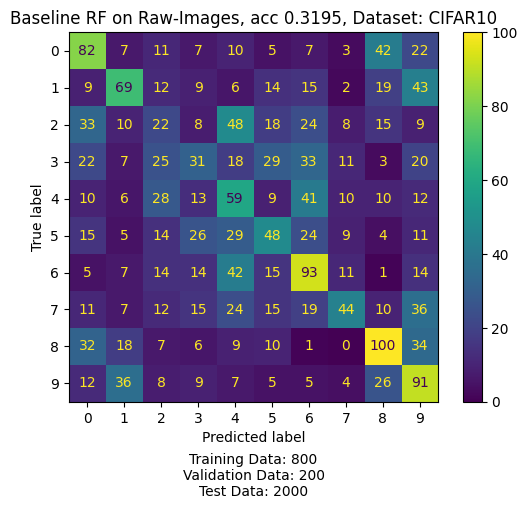

In [32]:
pred=clf.predict(x_test_rf)
# get confusion matrix
cm = confusion_matrix(np.argmax(y_test_new, axis=1), pred)
acc_fc = np.sum(pred == np.argmax(y_test_new, axis=1)) / len(np.argmax(y_test_new, axis=1))
print("Accuracy = " , acc_fc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title(f'Baseline RF on Raw-Images, acc {acc_fc}, Dataset: {data_set_name}')
plt.text(0.5, -0.2, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed
plt.show()


## Baseline: A CNN trained from scratch

In [58]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input
from keras.layers import Convolution2D, MaxPooling2D, Flatten, RandomFlip, RandomRotation, RandomContrast, RandomZoom, Rescaling
from keras.optimizers import Adam

In [59]:
# here we define hyperparameter of the NN
batch_size = 128
nb_epoch = 50
img_rows, img_cols = height, width
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

#### Data Augmentation

The following shows the effect of data augmentation.

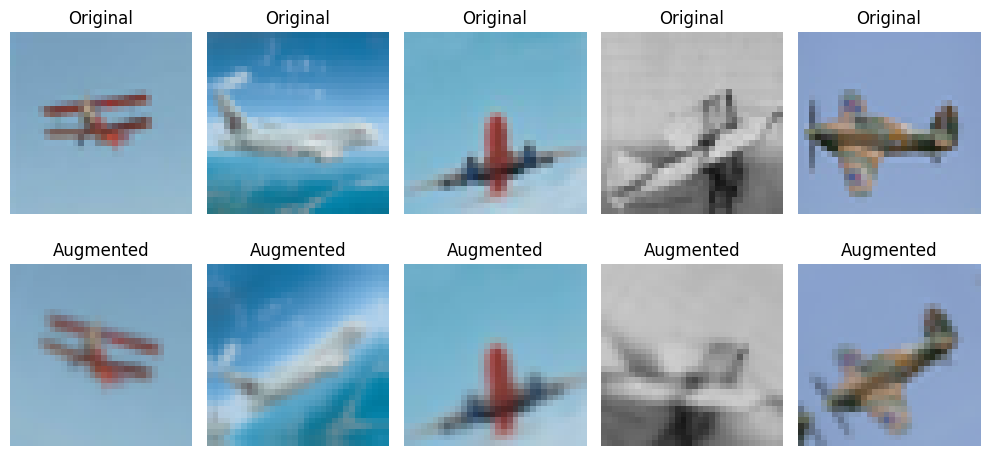

In [84]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    #RandomFlip("horizontal"),       # Randomly flip images horizontally
    RandomRotation(0.1),            # Randomly rotate images by 10%
    RandomZoom(0.1),                # Randomly zoom in on images
    #RandomContrast(0.1),            # Adjust contrast randomly
], name='Augmentation')

# Apply augmentation
augmented_images = data_augmentation(x_train_new[0:10])

# Display original and augmented images
plt.figure(figsize=(10, 5))

for i in range(5):
    # Original images
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")

    # Augmented images
    plt.subplot(2, 5, i + 6)
    plt.imshow(augmented_images[i].cpu().numpy().astype("uint8"))  # Convert tensor back to NumPy
    plt.title("Augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Definition of the model

Note that Augmentation boosts performance but slows down learninh

In [86]:
# Functional API Model Definition
inputs = Input(shape=input_shape)

if do_augmentation: # Augmentation with
  x = data_augmentation(inputs)
else:
  x = inputs

#x = Rescaling(1./255)(x)  # Normalize pixel values to [0, 1] mixed empirical results here

# First Convolutional Block
x = Convolution2D(8, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Convolution2D(8, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)

# Second Convolutional Block
x = Convolution2D(16, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Convolution2D(16, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)

# Fully Connected Layers
x = Flatten()(x)
x = Dense(40)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Activation('relu')(x)

# Output Layer
outputs = Dense(num_classes, activation='softmax')(x)

# Create Model
model = Model(inputs=inputs, outputs=outputs)

# Compile Model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

# Model Summary
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Augmentation (Sequential) │ (None, 32, 32, 3)      │              0 │ input_layer_19[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 32, 32, 8)      │            224 │ Augmentation[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_40    │ (None, 32, 32, 8)      │             32 │ conv2d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_40             │ (None, 32, 32, 8)      │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 32, 32, 8)      │            584 │ activation_40[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_41    │ (None, 32, 32, 8)      │             32 │ conv2d_34[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_41             │ (None, 32, 32, 8)      │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_16          │ (None, 16, 16, 8)      │              0 │ activation_41[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 16, 16, 16)     │          1,168 │ max_pooling2d_16[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 16, 16, 16)     │             64 │ conv2d_35[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_42             │ (None, 16, 16, 16)     │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 16, 16, 16)     │          2,320 │ activation_42[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 16, 16, 16)     │             64 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_43             │ (None, 16, 16, 16)     │              0 │ batch_normalization_4… │
│ (Activation)         

 Total params: 46,058 (179.91 KB)

 Trainable params: 45,882 (179.23 KB)

 Non-trainable params: 176 (704.00 B)

In [72]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=50,                 # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True    # Restore model weights from the epoch with the best value of the monitored quantity
)

history = model.fit(
    x_train_new[train_indices],
    y_train_new[train_indices],
    batch_size=128,
    epochs=nb_epoch,
    verbose=1,
    validation_data=(x_train_new[val_indices], y_train_new[val_indices]),
    shuffle=True,
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.1030 - loss: 2.7265 - val_accuracy: 0.1250 - val_loss: 6.3069
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 419ms/step - accuracy: 0.1927 - loss: 2.3071 - val_accuracy: 0.1100 - val_loss: 6.6738
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.2499 - loss: 2.1715 - val_accuracy: 0.1000 - val_loss: 5.4355
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.2514 - loss: 2.0644 - val_accuracy: 0.0800 - val_loss: 5.0922
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.2699 - loss: 2.0386 - val_accuracy: 0.1100 - val_loss: 3.7010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.3320 - loss: 1.8969 - val_accuracy: 0.1200 - val_loss: 3.0488
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.3501 - loss: 1.8614 - val_accuracy: 0.1350 - val_loss: 3.2118
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.3595 - loss: 1.8187 - val_accuracy: 0.1450 - val_loss:

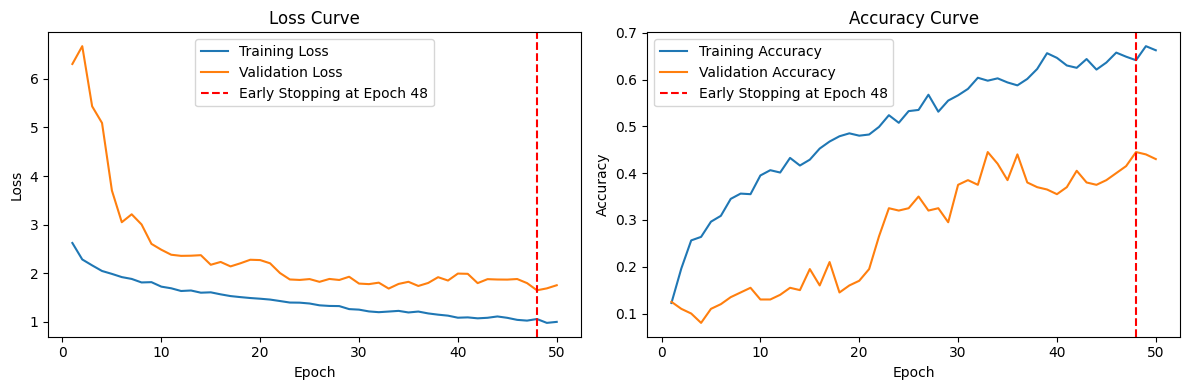

Training completed all epochs.
Best model weights were restored from epoch 48


In [87]:
# Retrieve the best epoch (zero-based index)
best_epoch = early_stopping.best_epoch

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Adjust epoch numbering to start from 1
epochs = np.arange(1, len(history.history['loss']) + 1)

# Plot loss
axes[0].plot(epochs, history.history['loss'], label='Training Loss')
axes[0].plot(epochs, history.history['val_loss'], label='Validation Loss')
axes[0].axvline(best_epoch + 1, color='r', linestyle='--',
                label=f'Early Stopping at Epoch {best_epoch + 1}')  # Include early stopping in legend
axes[0].set_title('Loss Curve')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Plot accuracy
axes[1].plot(epochs, history.history['accuracy'], label='Training Accuracy')
axes[1].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
axes[1].axvline(best_epoch + 1, color='r', linestyle='--',
                label=f'Early Stopping at Epoch {best_epoch + 1}')  # Include early stopping in legend
axes[1].set_title('Accuracy Curve')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()

# Print early stopping information
if early_stopping.stopped_epoch > 0:
    print(f"Training stopped after epoch {early_stopping.stopped_epoch + 1}")
else:
    print("Training completed all epochs.")

print(f"Best model weights were restored from epoch {best_epoch + 1}")

### Evaluation of the CNN classifier that was trained from scratch

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Accuracy =  0.403


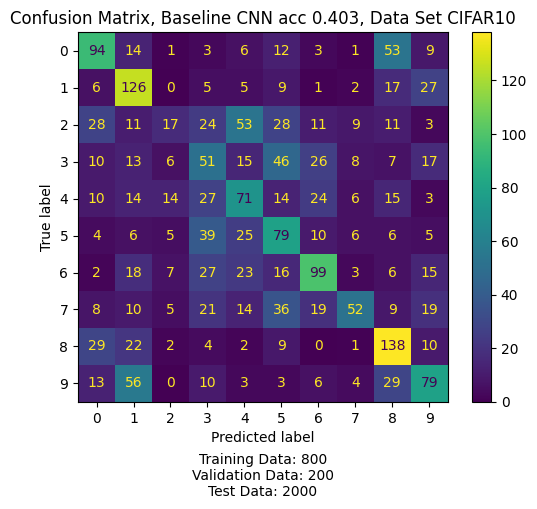

In [74]:
pred=model.predict(x_test_new)
cm = confusion_matrix(np.argmax(y_test_new,axis=1), np.argmax(pred,axis=1))
acc_cnn = np.sum(np.argmax(y_test_new,axis=1)==np.argmax(pred,axis=1))/len(y_test_new)
print("Accuracy = " , acc_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix, Baseline CNN acc {acc_cnn}, Data Set {data_set_name}')
plt.text(0.5, -0.2, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed
plt.show()

# Section 2 Using Feature Extraction from a pretrained NN

In [ ]:
#### Helper Function to store extracted features

In [ ]:
import gzip
def save_features_to_gz(features, filename, idx=None):
    """Saves features to a gzip-compressed CSV file.

    Args:
        features: A NumPy array of features.
        filename: The name of the output file (including .gz extension).
        idx: An optional array of indices. If provided, it will be
             included as the first column in the output file.
    """
    # If no indices are provided, use default range
    if idx is None:
        idx = np.arange(features.shape[0])

    # Reshape indices to a column vector and combine with features
    idx_col = idx.reshape(-1, 1)
    data_to_save = np.concatenate([idx_col, features], axis=1)

    # Write data to gzip file
    with gzip.open(filename, 'wt', encoding='utf-8') as f:
        # Write header with column names
        header = 'idx_zero_based,' + ','.join([f'f{i}' for i in range(1, features.shape[1] + 1)])
        f.write(header + '\n')
        # Save the combined data
        np.savetxt(f, data_to_save, delimiter=',', fmt='%s')

## VGG features Extractor (using keras)


In [ ]:
if (extractor_name == 'VGG16'):
  import keras
  from keras.models import Model
  from keras.applications.vgg16 import VGG16, preprocess_input
  # Load VGG16 model (pretrained on ImageNet)
  base_model = VGG16(weights='imagenet', include_top=True)
  base_model.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
if (extractor_name == 'VGG16'):
  # prompt: Refactor the cell above to include a function called feature extractor VGG16 which can be reused for the validation and testset

  def feature_extractor_vgg16(images, batch_size=128):
    """
    Extracts VGG16 features from a set of images using batching for efficiency.

    Args:
        images: A list or array of images (NumPy arrays).
        batch_size: Number of images to process in one batch.

    Returns:
        A NumPy array of extracted VGG16 features.
    """
    # Load VGG16 model (pretrained on ImageNet)
    base_model = VGG16(weights='imagenet', include_top=True)

    # Create a feature extractor by selecting the 'fc2' layer
    feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

    vgg16_features = []

    # Preprocess all images first (resize, normalize, etc.)
    preprocessed_images = []
    for img_array in tqdm(images, desc="Preprocessing Images", total=len(images)):
        img = Image.fromarray(img_array.astype('uint8'), 'RGB').resize((224, 224))  # Resize to (224, 224)
        img_array = np.array(img)
        img_array = preprocess_input(img_array)  # Apply VGG16-specific preprocessing
        preprocessed_images.append(img_array)

    preprocessed_images = np.array(preprocessed_images)  # Convert to numpy array for batching

    # Process in batches
    num_batches = int(np.ceil(len(preprocessed_images) / batch_size))

    for i in tqdm(range(num_batches), desc="Extracting VGG16 Features"):
        batch_images = preprocessed_images[i * batch_size : (i + 1) * batch_size]
        features = feature_extractor.predict(batch_images, verbose=0)
        vgg16_features.append(features)

    # Concatenate all features into a single numpy array
    vgg16_features = np.concatenate(vgg16_features, axis=0)

    return vgg16_features

  features_train_vgg16 = feature_extractor_vgg16(x_train_new)
  features_test_vgg16 = feature_extractor_vgg16(x_test_new)
  features_train = features_train_vgg16
  features_test = features_test_vgg16
else:
  display(Markdown('**Skipping Cell: Not VGG16 Extractor**'))

Extracting VGG16 Features: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]


## Resnet Extractor

In [ ]:
if (extractor_name == 'ResNet-18'):
  from PIL import Image
  import numpy as np
  from tqdm import tqdm
  import torch
  from torchvision import models, transforms

  # Load ResNet-18 model (pretrained on ImageNet)
  def load_resnet18_model():
      model = models.resnet18(pretrained=True)
      model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the final fully connected layer
      model.eval()  # Set model to evaluation mode
      return model

  # Define preprocessing steps to match ResNet-18 requirements
  resnet_transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize to match ResNet input
      transforms.ToTensor(),          # Convert PIL Image to Tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
  ])

  def feature_extractor_resnet18(images):
      """
      Extracts ResNet-18 features from a set of images.

      Args:
          images: A list or array of images (NumPy arrays).

      Returns:
          A NumPy array of extracted ResNet-18 features.
      """
      model = load_resnet18_model()

      resnet_features = []
      for img_array in tqdm(images, desc="Extracting ResNet-18 Features", total=len(images)):
          # Convert NumPy array to PIL Image
          img = Image.fromarray(img_array.astype('uint8'), 'RGB')

          # Apply preprocessing
          img_tensor = resnet_transform(img).unsqueeze(0)  # Add batch dimension

          # Extract features without computing gradients
          with torch.no_grad():
              features = model(img_tensor).squeeze().numpy()  # Output shape: (512,)

          resnet_features.append(features.flatten())  # Flatten to a 1D vector

      return np.array(resnet_features)

  # Apply feature extraction to datasets
  features_train = feature_extractor_resnet18(x_train_new)
  features_test = feature_extractor_resnet18(x_test_new)
else:
  display(Markdown('**Skipping Cell: Not ResNet-18 Extractor**'))

**Skipping Cell: Not ResNet-18 Extractor**

## Mobilnet Extractor

In [ ]:
if (extractor_name == 'mobilnet'):
  from PIL import Image
  import numpy as np
  from tqdm import tqdm
  import torch
  from torchvision import models, transforms

  # Load MobileNetV2 model (pretrained on ImageNet)
  def load_mobilenetv2_model():
      model = models.mobilenet_v2(pretrained=True)
      feature_extractor = torch.nn.Sequential(*list(model.features), torch.nn.AdaptiveAvgPool2d((1, 1)))  # Remove classifier
      feature_extractor.eval()  # Set model to evaluation mode
      return feature_extractor

  # Define preprocessing steps to match MobileNetV2 requirements
  mobilenet_transform = transforms.Compose([
      transforms.Resize((96, 96)),  # Resize to match MobileNetV2 input
      transforms.ToTensor(),        # Convert PIL Image to Tensor
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
  ])


  def feature_extractor_mobilenetv2(images):
      """
      Extracts MobileNetV2 features from a set of images.

      Args:
          images: A list or array of images (NumPy arrays).

      Returns:
          A NumPy array of extracted MobileNetV2 features.
      """
      model = load_mobilenetv2_model()

      mobilenet_features = []
      for img_array in tqdm(images, desc="Extracting MobileNetV2 Features", total=len(images)):
          # Convert NumPy array to PIL Image
          img = Image.fromarray(img_array.astype('uint8'), 'RGB')

          # Apply preprocessing
          img_tensor = mobilenet_transform(img).unsqueeze(0)  # Add batch dimension

          # Extract features without computing gradients
          with torch.no_grad():
              features = model(img_tensor).squeeze().numpy()  # Output shape: (1280,)

          mobilenet_features.append(features.flatten())  # Flatten to a 1D vector

      return np.array(mobilenet_features)

  # Apply feature extraction to datasets
  features_train = feature_extractor_mobilenetv2(x_train_new)
  features_test = feature_extractor_mobilenetv2(x_test_new)
else:
  display(Markdown('**Skipping Cell: Not MobileNet Extractor**'))


**Skipping Cell: Not MobileNet Extractor**

## SWIN Extractor

In [ ]:
%%time
if (extractor_name == 'swin'):
  from transformers import SwinModel, AutoFeatureExtractor
  import torch
  from PIL import Image
  import numpy as np
  from tqdm import tqdm

  def get_swin_features(images, batch_size=32, device='cuda' if torch.cuda.is_available() else 'cpu'):
      """
      Extracts Swin Transformer features from a set of images using batching.

      Args:
          images: A list or array of images (NumPy arrays).
          batch_size: Number of images to process at once.
          device: The device to run the model on ('cuda' or 'cpu').

      Returns:
          A NumPy array of extracted Swin features.
      """
      model_name = "microsoft/swin-base-patch4-window7-224"
      model = SwinModel.from_pretrained(model_name).to(device)
      model.eval()
      feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

      swin_features = []
      num_batches = len(images) // batch_size + int(len(images) % batch_size != 0)

      for i in tqdm(range(num_batches), desc="Extracting Swin Features"):
          batch_images = images[i * batch_size: (i + 1) * batch_size]

          # Convert batch of NumPy arrays to list of PIL Images
          pil_images = [Image.fromarray(img.astype('uint8'), 'RGB') for img in batch_images]

          # Preprocess the batch
          inputs = feature_extractor(images=pil_images, return_tensors="pt").to(device)

          # Get model outputs
          with torch.no_grad():
              outputs = model(**inputs)

          # Extract features and move to CPU
          features = outputs.pooler_output.cpu().numpy()  # Shape: (batch_size, hidden_size)
          swin_features.append(features)

      return np.vstack(swin_features)  # Combine all batches into a single array

  # Example usage
  features_train = get_swin_features(x_train_new, batch_size=32)
  features_test = get_swin_features(x_test_new, batch_size=32)
else:
  display(Markdown('**Skipping Cell: Not swin Extractor**'))

**Skipping Cell: Not swin Extractor**

CPU times: user 2.43 ms, sys: 21 µs, total: 2.45 ms
Wall time: 2.14 ms


In [ ]:
features_train.shape
idx = np.arange(features_train.shape[0])
idx.shape

(1000,)

In [ ]:
# Example usage (assuming features_cifar_train, features_cifar_valid, and features_cifar_test are defined):
save_features_to_gz(features_train, f'{PATH}/features_{data_set_name}_{extractor_name}_train.gz', idx)
save_features_to_gz(features_test, f'{PATH}/features_{data_set_name}_{extractor_name}_test.gz')

In [ ]:
print(data_set_name, " ", extractor_name)
print(features_train.shape)
print(features_test.shape)

CIFAR10   VGG16
(1000, 4096)
(2000, 4096)


# Section 3: Use extracted features

## Random Forest model on extracted features

In [ ]:
clf = RandomForestClassifier(oob_score=True)
clf.fit(features_train[train_indices],np.argmax(y_train_new[train_indices], axis=1))
clf.oob_score_

0.72375

Accuracy =  0.7495


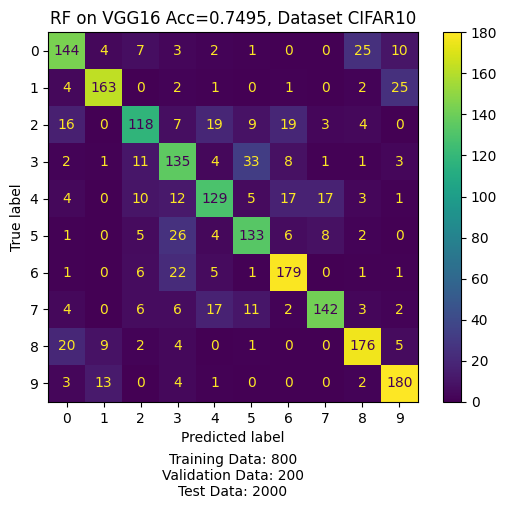

In [ ]:
pred=clf.predict(features_test)
# get confusion matrix
cm = confusion_matrix(np.argmax(y_test_new, axis=1), pred)

acc_feature_rf = np.sum(pred==np.argmax(y_test_new, axis=1))/len(np.argmax(y_test_new, axis=1))
print("Accuracy = " ,acc_feature_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title(f'RF on {extractor_name} Acc={acc_feature_rf}, Dataset {data_set_name}')
plt.text(0.5, -0.2, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed
plt.show();

## 🔧 Fully Connected NN on extracted features

### 🔧 Your Task:
  - fill in the missing Code below


In [ ]:
input_shape = features_train.shape[1]
input_shape
y_train_new.shape

(1000, 10)

In [ ]:
model = Sequential()
model.add(Dense(200,input_shape=(input_shape,)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(Dense(200))

# we still need to add the last layers to get the predictions on the 10 classes

#######🔧  your code here  ######



####### 🔧 end of your code ######


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# @title 🔑 Solution Code { display-mode: "form" }

### use these layers
model.add(Dense(num_classes))
model.add(Activation('softmax'))
###

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 200)                 │         819,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 10)                  │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 862,410 (3.29 MB)

 Trainable params: 862,010 (3.29 MB)

 Non-trainable params: 400 (1.56 KB)

In [ ]:
history=model.fit(features_train[train_indices], y_train_new[train_indices],
                  batch_size=10,
                  epochs=20,
                  verbose=2,
                  validation_data=(features_train[val_indices], y_train_new[val_indices]),shuffle=True)

Epoch 1/20
80/80 - 1s - 9ms/step - accuracy: 0.5600 - loss: 1.3647 - val_accuracy: 0.7050 - val_loss: 0.9984
Epoch 2/20
80/80 - 1s - 9ms/step - accuracy: 0.7475 - loss: 0.7326 - val_accuracy: 0.6800 - val_loss: 1.2110
Epoch 3/20
80/80 - 1s - 9ms/step - accuracy: 0.8225 - loss: 0.5371 - val_accuracy: 0.7300 - val_loss: 0.9311
Epoch 4/20
80/80 - 1s - 9ms/step - accuracy: 0.8413 - loss: 0.4619 - val_accuracy: 0.7450 - val_loss: 0.8811
Epoch 5/20
80/80 - 1s - 9ms/step - accuracy: 0.8838 - loss: 0.3486 - val_accuracy: 0.7300 - val_loss: 0.9375
Epoch 6/20
80/80 - 1s - 9ms/step - accuracy: 0.8800 - loss: 0.3290 - val_accuracy: 0.7400 - val_loss: 0.8375
Epoch 7/20
80/80 - 1s - 9ms/step - accuracy: 0.8950 - loss: 0.3003 - val_accuracy: 0.7350 - val_loss: 0.8792
Epoch 8/20
80/80 - 1s - 9ms/step - accuracy: 0.9137 - loss: 0.2744 - val_accuracy: 0.7400 - val_loss: 0.8835
Epoch 9/20
80/80 - 1s - 8ms/step - accuracy: 0.9237 - loss: 0.2322 - val_accuracy: 0.7250 - val_loss: 0.9477
Epoch 10/20
80/80 -

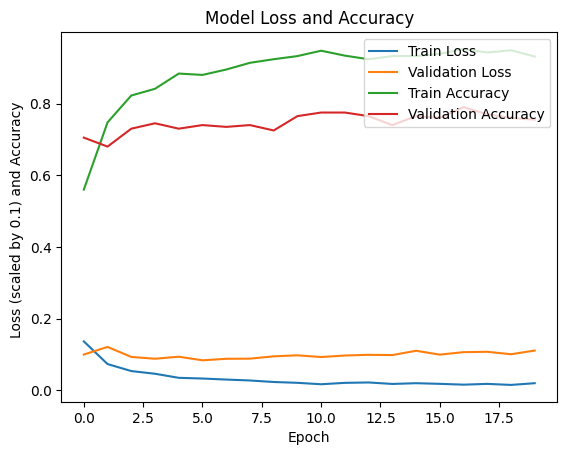

In [ ]:
# prompt: Plot loss curve and include accurracy divide loss by 10

import matplotlib.pyplot as plt
# ... (rest of your existing code)

# Assuming 'history' is the object returned by model.fit
plt.plot(np.array(history.history['loss']) / 10.)  # Divide loss by 10 using numpy array
plt.plot(np.array(history.history['val_loss']) / 10.)  # Divide validation loss by 10 using numpy array
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Loss and Accuracy')
plt.ylabel('Loss (scaled by 0.1) and Accuracy ')
plt.xlabel('Epoch')
plt.legend(['Train Loss', 'Validation Loss', 'Train Accuracy', 'Validation Accuracy'], loc='upper right')
plt.show()

## 🔧 Evaluation of the NN classifier that was trained on VGG features


### 🔧 Your Task:
  - fill in the missing Code below. From the predicitons `pred` plot the confusion matrix and calculate accuracy

  
  ` acc_feature_nn=`


In [ ]:
pred=model.predict(features_test)
# get confusion matrix
#### we now want to get the confusion matrix for the predictions on the test data

#######🔧  your code here  ######


####### 🔧 end of your code ######

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Accuracy =  0.7645


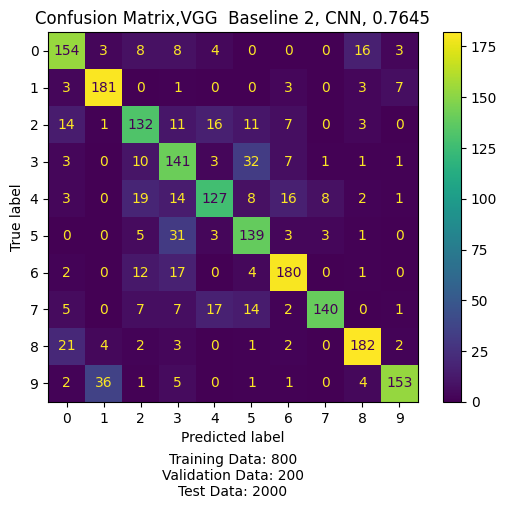

In [ ]:
# @title 🔑 Solution Code { display-mode: "form" }
cm = confusion_matrix(np.argmax(y_test_new,axis=1),np.argmax(pred,axis=1))

acc_feature_nn = np.sum(np.argmax(y_test_new,axis=1)==np.argmax(pred,axis=1))/len(y_test_new)
print("Accuracy = " , acc_feature_nn)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='viridis')
plt.title(f'Confusion Matrix,VGG  Baseline 2, CNN, {acc_feature_nn}')
plt.text(0.5, -0.2, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed

plt.show();

In [ ]:
print(f"""
Data Set: {data_set_name}
Extractor: {extractor_name}
{text_info}


Data        |      Model      |  Accuracy
------------|-----------------|----------
RAW         | Random Forest   | {acc_fc:.4f}
RAW         | CNN             | {acc_cnn:.4f}
Features| Random Forest   | {acc_feature_rf:.4f}
Features| Neural Network  | {acc_feature_nn:.4f}
""")



Data Set: CIFAR10
Extractor: VGG16
Training Data: 800
Validation Data: 200
Test Data: 2000


Data        |      Model      |  Accuracy
------------|-----------------|----------
RAW         | Random Forest   | 0.3195
RAW         | CNN             | 0.3020
Features| Random Forest   | 0.7495
Features| Neural Network  | 0.7645



# Bonus t-SNE visualization

We know use the extracted image features to visualize the similarities of the images in a t-SNE plot. Note that no label are used to compute the positions in the t-SNE plot.  

In [ ]:
# Reduce dimensionality to 2 components using t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(features_train)

<ipython-input-46-abe45ae2d91e>:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Discrete color map


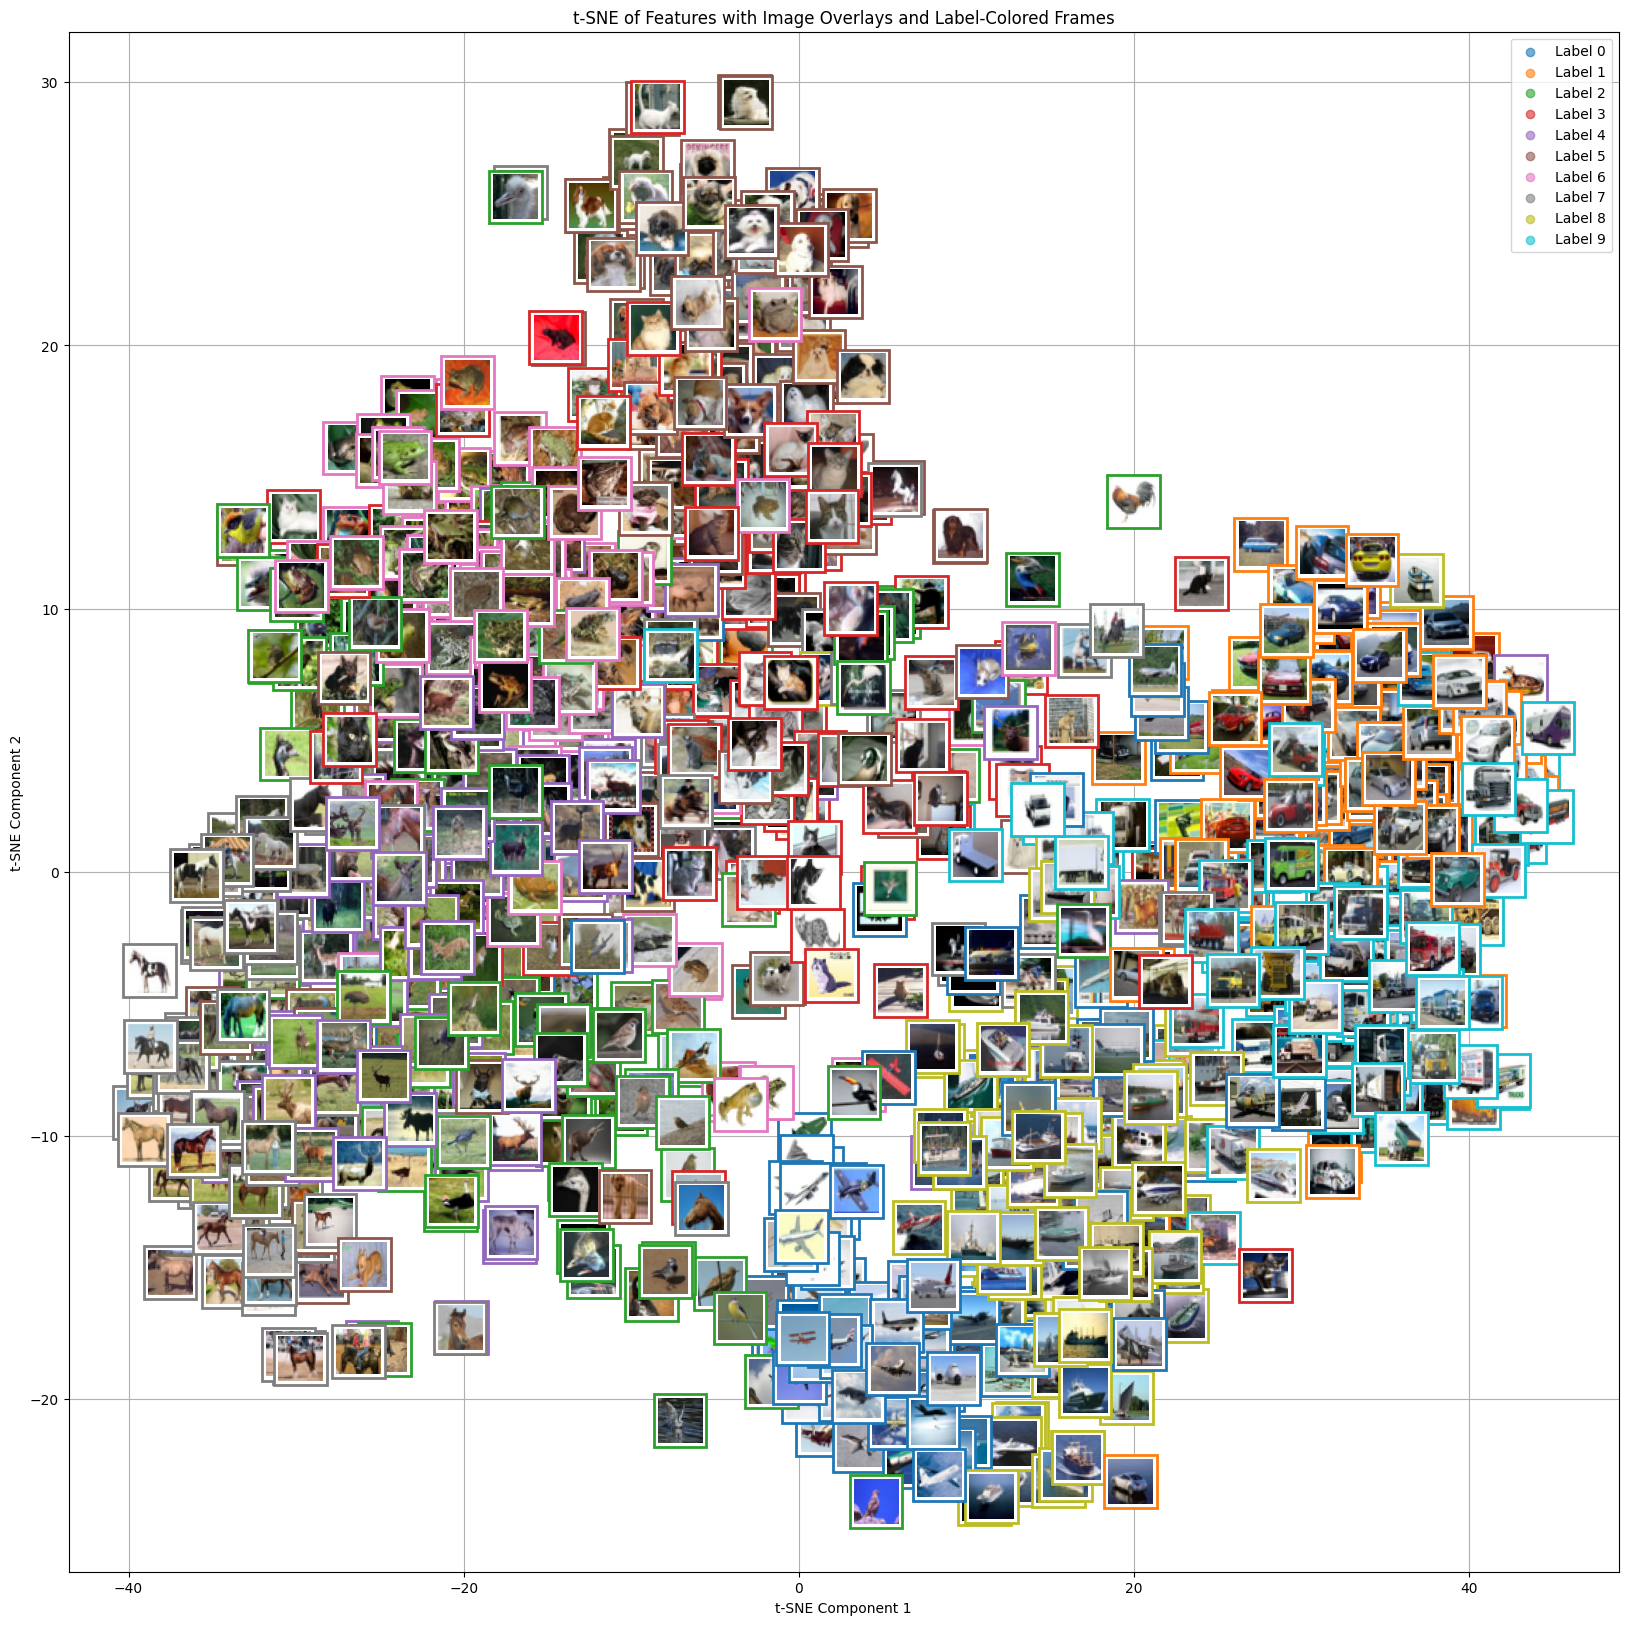

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

size = 20
zoom = 1

# Assuming features_train, y_train_new, and x_train_new are already defined

# Get unique labels for discrete color scaling
unique_labels = np.unique(np.argmax(y_train_new, axis=1))
colors = plt.cm.get_cmap('tab10', len(unique_labels))  # Discrete color map

# Create scatter plot
fig, ax = plt.subplots(figsize=(size, size))
for label in unique_labels:
    indices = np.where(np.argmax(y_train_new, axis=1) == label)
    ax.scatter(tsne_result[indices, 0], tsne_result[indices, 1],
               color=colors(label), label=f"Label {label}", alpha=0.6)

# Randomly select a subset of images to overlay
num_images_to_display = min(1000, len(x_train_new))
random_indices = np.random.choice(len(x_train_new), num_images_to_display, replace=False)

# Overlay images at t-SNE coordinates with frames matching class labels
for idx in random_indices:
    img = x_train_new[idx]
    label = np.argmax(y_train_new[idx])
    frame_color = colors(label)  # Get color for the current label

    if img.ndim == 2:  # Grayscale images
        imagebox = OffsetImage(img, cmap='gray', zoom=zoom)
    else:  # RGB images
        imagebox = OffsetImage(img, zoom=zoom)

    x, y = tsne_result[idx, 0], tsne_result[idx, 1]
    ab = AnnotationBbox(imagebox, (x, y), frameon=True, pad=0.3,
                        bboxprops=dict(edgecolor=frame_color, linewidth=2))
    ax.add_artist(ab)

ax.set_xlabel("t-SNE Component 1")
ax.set_ylabel("t-SNE Component 2")
ax.set_title("t-SNE of Features with Image Overlays and Label-Colored Frames")
ax.legend()
ax.grid(True)

fig.savefig(f'{PATH}/features_{data_set_name}_{extractor_name}_{num_images_to_display}_tSNE.svg', format='svg')
fig.savefig(f'{PATH}/features_{data_set_name}_{extractor_name}_{num_images_to_display}_tSNE.pdf', format='pdf')
fig.savefig(f'{PATH}/features_{data_set_name}_{extractor_name}_{num_images_to_display}_tSNE.png', format='png')

# Display the plot
plt.show()